<a href="https://colab.research.google.com/github/Anubhab0410/Generative-AI-Sketch-to-Real-Interior-Designer/blob/main/ControlNet_LoRA_FineTune_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install -U diffusers transformers accelerate datasets
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121


In [ ]:
import torch
import os
from google.colab import drive
from datasets import load_dataset
from diffusers import ControlNetModel, StableDiffusionControlNetPipeline, UniPCMultistepScheduler

drive.mount('/content/drive')

DRIVE_DATA_DIR = "/content/drive/MyDrive/interior_design_dataset_A/content/interior_dataset"

dataset = load_dataset("json", data_files=os.path.join(DRIVE_DATA_DIR, "train.jsonl"))

def map_paths(example):
    example["image"] = os.path.join(DRIVE_DATA_DIR, example["image"])
    example["conditioning_image"] = os.path.join(DRIVE_DATA_DIR, example["conditioning_image"])
    return example

train_dataset = dataset['train'].map(map_paths)
print(f"✅ Ready! Loaded {len(train_dataset)} pairs.")

In [ ]:

controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/sd-controlnet-canny",
    torch_dtype=torch.float16
)

pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet,
    torch_dtype=torch.float16
).to("cuda")

pipe.enable_attention_slicing()
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

print("🚀 Pipeline is live and GPU-accelerated.")

  0%|          | 0/50 [00:00<?, ?it/s]

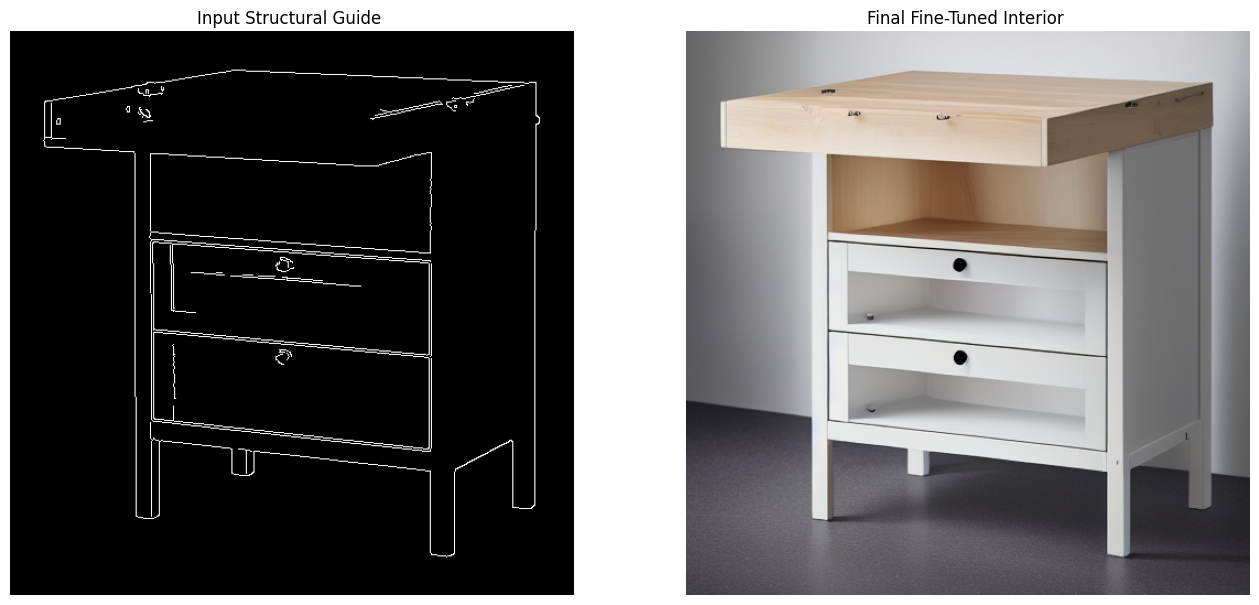

In [8]:

sample_idx = 149
test_sketch = load_image(train_dataset[sample_idx]['conditioning_image'])


prompt = (
    "A professional IKEA catalogue photo, Scandinavian minimalist interior, "
    "light birch wood textures, soft natural daylight, high-end furniture, "
    "8k UHD, architectural photography, neutral color palette, realistic shadows"
)
negative_prompt = "blurry, low quality, distorted furniture, messy, dark, noisy"

with torch.inference_mode():
    result = pipe(
        prompt,
        negative_prompt=negative_prompt,
        image=test_sketch,
        num_inference_steps=50,
        controlnet_conditioning_scale=0.8,
        guidance_scale=8.5
    ).images[0]

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].imshow(test_sketch, cmap='gray'); ax[0].set_title("Input Structural Guide ")
ax[1].imshow(result); ax[1].set_title("Final Fine-Tuned Interior ")
for a in ax: a.axis('off')
plt.show()